# Decitabine and rg3039 treatment RNA-Seq experiments
Decitabine -> DNMT1 inhibitor 

rg3039 -> DCPS inhibitor

- ### [Pre-processing](#Pre-processing)
- ### [Differential expression analysis using `DESeq2`](#Differential-expression-analysis-using-DESeq2)

# Pre-processing 

I'm mapping `hg38/gencode.v34` to the `fastq` files using salmon. 

In [1]:
# %%bash 
# nohup bash scripts/salmon.sh \
# ~/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-exp \
# ~/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-fastq \
# ~/genomes/hg38/gencode.v34/salmon_index/ > hl60-salmon.out&

# Differential expression analysis using `DESeq2`

## Load packages and functions

In [2]:
# %load_ext rpy2.ipython

In [3]:
# %%R 
suppressMessages(suppressWarnings(library (GenomicFeatures)))
suppressMessages(suppressWarnings(library (tximport)))
suppressMessages(suppressWarnings(library (tidyverse)))
suppressMessages(suppressWarnings(library (ggplot2)))
suppressMessages(suppressWarnings(library (ggrepel)))
suppressMessages(suppressWarnings(library (DESeq2)))
suppressMessages(suppressWarnings(library (patchwork)))
suppressMessages(suppressWarnings(library (BiocParallel)))
suppressMessages(suppressWarnings(library(gridExtra)))
library(grid)
library(ggthemes)

register(MulticoreParam(18))

In [4]:
source("../../scripts/util.R")

- https://medium.com/analytics-vidhya/ggplot2-themes-for-publication-ready-plots-including-dark-themes-9cd65cc5a7e3

- https://rpubs.com/Koundy/71792

In [5]:
# Filter non-informative genes:
filter_low_counts <- function (dds_in , min_count=10){
    # all samples with a count of higher than `min_count`
    keep <- rowSums(counts(dds_in ) > min_count) == ncol(dds_in )
    # at least 3 samples with a count of 10 or higher
    # keep <- rowSums(counts(dds) >= 10) >= 3
    dds_out <- dds_in [keep,]
    print (paste (nrow(dds_in), 'genes filtered to ->' , nrow(dds_out),'genes!', sep=' ') )
    return (dds_out)
}


plot_PCA <- function(vsd, colData, labels='', gr=c('cond'), title='', leg="none"){
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) +
            geom_point(aes(colour=group), alpha = 4/10,size=12) + 
            geom_point(shape = 1,size = 12,colour = "black") + 
            # geom_point(
            #     aes(color=group), 
            #     
            # size=10,
            # stroke = 0.5
            # ) +
            geom_text_repel(
                aes(label = labels),
                box.padding = 1.5, max.overlaps = Inf
            ) + #,size = 3.5)) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            ggtitle (title) + 
            scale_colour_Publication() + 
            theme_Publication(legend.position='top') +
            guides (size = 'none') + theme(legend.title = element_blank()) 
    return (pca)
}

In [6]:
write_Result <- function(res, name_it, col=FALSE, row=FALSE){
    write.table(res,name_it, sep="\t", quote=FALSE, col.names=col, row.names=row)
}


correct_batch <- function (dds,gr,out,labels='',title=''){
    vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
    p0 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' Before removeBatchEffect'))
    mat <- assay(vsd)
    
    mat <- limma::removeBatchEffect(mat, vsd$reps) # batch is same as time 
    assay(vsd) <- mat
    p1 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' After removeBatchEffect'))
    counts_batch_corrected <- assay(vsd)
    
    if (out == 'plot') {return (p0 + p1)}
    if (out == 'plot1'){return (p1)}
    if (out == 'vsd')  {return (vsd)}
    if (out == 'cbc')  {return (counts_batch_corrected)}
}


ann_Result <- function(res){
    return (
        res %>% data.frame %>% 
        add_column(gene_name=gene2name[rownames(res),]) %>%
        add_column(gene_id=rownames(res)) %>% 
        select (gene_id,gene_name,everything())
    )
}

plot_gene_counts <- function (dds, gene_id,gene_name){
    fiss <- plotCounts(dds, gene_id, intgroup = c("cond"), returnData = TRUE)

    p <- ggplot(fiss,
      aes(x = cond, y = count, color = cond)) + 
      geom_point(size=5,alpha=8/10) + stat_summary(fun=mean, geom="line") +
      scale_y_log10() + 
      theme_bw() + 
      ggtitle(gene_name)
    
    return (p + theme_Publication())
}

## Load annotations

In [7]:
# %%R
GTF = '~/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf'
gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% 
    data.frame %>% 
    column_to_rownames('gene_id') %>% 
    dplyr::select('gene_name')

txdb  = makeTxDbFromGFF(GTF,organism='Homo sapiens')
# tx2gene objects 
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- AnnotationDbi::select(txdb, k, "GENEID", "TXNAME")

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK

'select()' returned 1:1 mapping between keys and columns



In [8]:
# %%R 
tx2name <- gtf[gtf$type == "transcript"] %>% 
    data.frame %>% column_to_rownames('transcript_id') %>% 
    dplyr::select('transcript_name')

## Load salmon quant files

List every salmon quant files

In [9]:
# %%R
files <- list.files(path='./quants', pattern="quant.sf",full.names = TRUE, recursive=T)
names(files) <- gsub("./quants/(\\S+)/quant.sf","\\1",files)

In [10]:
files

hl60_combination_1                     hl60_combination_2 
"./quants/hl60_combination_1/quant.sf" "./quants/hl60_combination_2/quant.sf" 
                     hl60_decitabine_1                      hl60_decitabine_2 
 "./quants/hl60_decitabine_1/quant.sf"  "./quants/hl60_decitabine_2/quant.sf" 
                           hl60_dmso_1                            hl60_dmso_2 
       "./quants/hl60_dmso_1/quant.sf"        "./quants/hl60_dmso_2/quant.sf" 
                         hl60_rg3039_1                          hl60_rg3039_2 
     "./quants/hl60_rg3039_1/quant.sf"      "./quants/hl60_rg3039_2/quant.sf"

In [11]:
txi <- tximport(files, type = "salmon", tx2gene = tx2gene, txOut=TRUE)

txi.gene <- summarizeToGene(txi, tx2gene, ignoreAfterBar= TRUE)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 


summarizing abundance

summarizing counts

summarizing length



In [12]:
names(files)

[1] "hl60_combination_1" "hl60_combination_2" "hl60_decitabine_1" 
[4] "hl60_decitabine_2"  "hl60_dmso_1"        "hl60_dmso_2"       
[7] "hl60_rg3039_1"      "hl60_rg3039_2"

### Define sample sheet

In [13]:
# meta 
conds  <- factor(c(
    rep('Combination',2),rep('Decitabine',2),rep('DMSO',2),rep('rg3039',2)
), levels = c('DMSO','Decitabine','rg3039','Combination'))

reps <- factor(c(
    rep(c('rep1','rep2'),4)
),c('rep1','rep2'))

colData <- data.frame(
    cond=conds,
    reps=reps,
    row.names=colnames(txi$abundance),
    stringsAsFactors=FALSE
)
colData

,cond,reps
,<fct>,<fct>
hl60_combination_1,Combination,rep1
hl60_combination_2,Combination,rep2
hl60_decitabine_1,Decitabine,rep1
hl60_decitabine_2,Decitabine,rep2
hl60_dmso_1,DMSO,rep1
hl60_dmso_2,DMSO,rep2
hl60_rg3039_1,rg3039,rep1
hl60_rg3039_2,rg3039,rep2


#### Make `DESeq` object

In [14]:
dds0 <- DESeqDataSetFromTximport(txi.gene, colData, ~cond)

using counts and average transcript lengths from tximport



#### Save normalized counts

In [15]:
dds1 <- estimateSizeFactors(dds0)

using 'avgTxLength' from assays(dds), correcting for library size



In [16]:
ncu <- counts(dds1, normalized=TRUE) %>% 
    data.frame %>% rownames_to_column('gene_id') %>% 
    add_column(gene_name=gene2name[rownames(dds1),], .after='gene_id')

In [17]:
write.table(
    ncu,'deseq2_norm.txt', sep="\t", quote=FALSE, col.names=TRUE
)

___

In [18]:
counts.raw <- counts(dds1, normalized=FALSE) %>% 
    data.frame %>% rownames_to_column('gene_id') %>% 
    add_column(gene_name=gene2name[rownames(dds1),], .after='gene_id')

In [19]:
write.table(
    counts.raw,'deseq2_raw_counts.txt',
    sep="\t", quote=FALSE, col.names=TRUE
)

___

In [20]:
counts.log2_tpm = log2 (t( t(counts(dds1)) * 1e6 / colSums(counts(dds1)) ) + 1)  %>% data.frame %>% 
    rownames_to_column('gene_id') %>% 
    add_column(gene_name=gene2name[rownames(dds1),], .after='gene_id')

In [21]:
write.table(
    counts.log2_tpm,'deseq2_counts_log2_tpm.txt',
    sep="\t", quote=FALSE, col.names=TRUE
)

In [22]:
counts.log2_tpm %>% filter(gene_name %in% c('CD14','ITGAM')) %>% t
# 'ITGAM' (CD11B)'
# )

gene_id,ENSG00000169896.18,ENSG00000170458.14
gene_name,ITGAM,CD14
hl60_combination_1,2.457506,4.628673
hl60_combination_2,2.591105,4.906686
hl60_decitabine_1,2.801105,3.294280
hl60_decitabine_2,2.802497,2.838397
hl60_dmso_1,1.970174,2.495470
hl60_dmso_2,2.157115,2.480899
hl60_rg3039_1,1.578623,4.031474
hl60_rg3039_2,1.770167,4.083683


> _In order to test for any differences over multiple time points, once can use a design including the time factor, and then test using the **likelihood ratio test (LRT)**. Here, as we have control (DMSO) and treatment (Decitabine) time series, design formula containing the condition factor, the time factor, and the interaction of the two. In this case, using the likelihood ratio test with a reduced model which does not contain the interaction terms will test whether the condition induces a change in gene expression at any time point after the reference level time point (time 0)._

> _(see [this](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#time-series-experiments)  OR [this](http://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#time-course-experiments) for more details about DESeq2 time series experiments)_

## PCA
<!-- Initial principal component analysis (PCA) shows the second treated biological replicate at 72h time point, behaves as an outlier. Removing that from the analysis give us a better representation of our dataset. In the second PCA plot, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis. -->


In [23]:
dds.pca <- DESeq(dds0, parallel=TRUE)
# results 
vsd <- varianceStabilizingTransformation(dds.pca)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



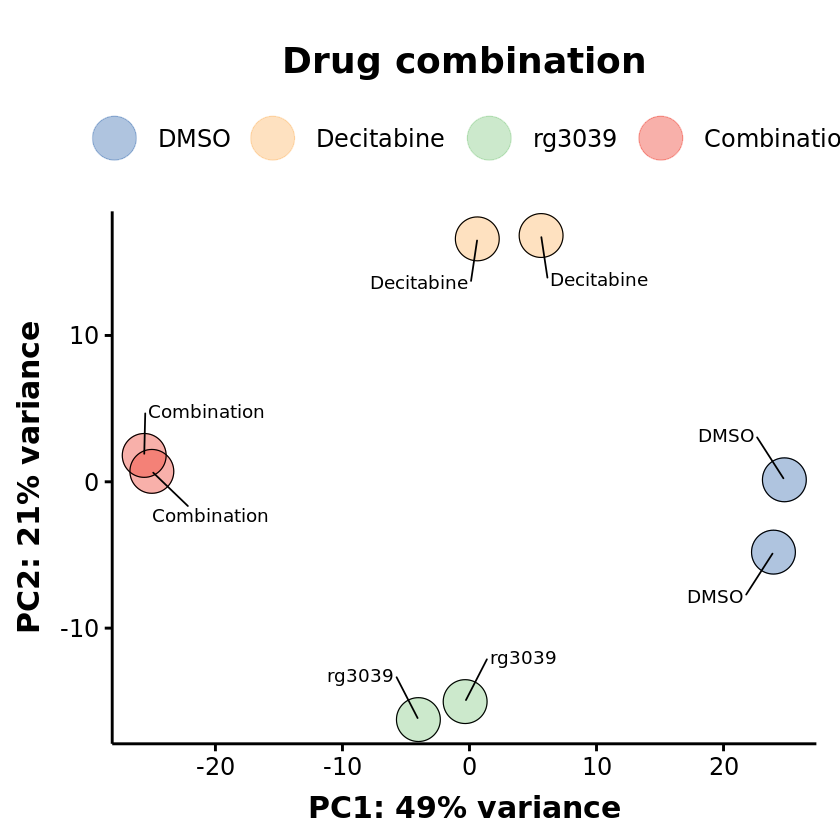

In [24]:
pca = plot_PCA(
    vsd, 
    colData(vsd), 
    labels=colData(vsd)[,'cond'],
    gr=c('cond'), title='Drug combination'
)
pca

In [25]:
ggsave('plots/pca.pdf',pca,width=6, height=6.8)

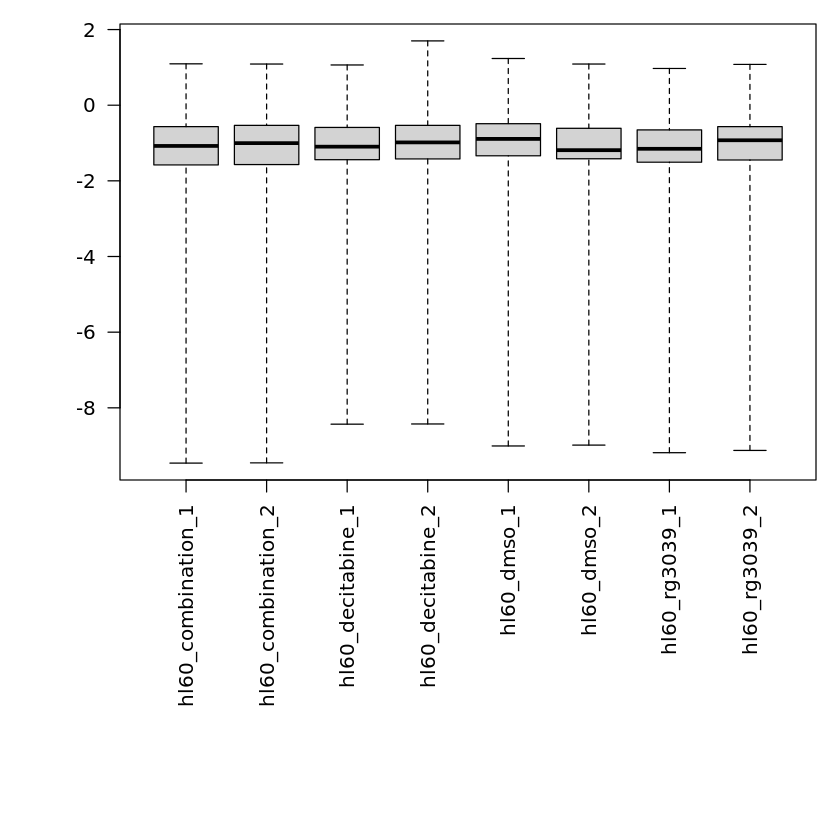

In [26]:
par(mar=c(15,5,1,1))
boxplot(log10(assays(dds.pca)[["cooks"]]), range=0, las=2)

## Differential expression analysis

<!-- We make two different `dds` object one with with no `cond:time` interaction term and the other one with the interaction term (**ANOVA-like comparison**).  -->

<!-- Then, I'm replacing results from first object to the secound one for genes with adjust p-values (padj) > 0.05. Hossien Asgharian told me these genes has more accurate estimation from the model with no interaction term.  -->

<!-- https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/designmatrices.html#design-matrices-with-and-without-intercept-term -->

### simple DESeq2!

In [27]:
dds_simple <- DESeqDataSetFromTximport(
    txi.gene, colData, ~0+cond
)

dds_simple <- DESeq(dds_simple, parallel=TRUE)

resultsNames(dds_simple)

# contrast design: combination treatment vs dmso 
res_comb_vs_dmso  = results(dds_simple, contrast=list(c('condCombination'),c('condDMSO')),listValues=c(1,-1))

res_comb_vs_dmso %>% summary

# contrast design: decitabine treatment vs dmso 
res_decitabine_vs_dmso  = results(dds_simple, contrast=list(c('condDecitabine'),c('condDMSO')),listValues=c(1,-1))

res_decitabine_vs_dmso %>% summary

# contrast design: combination treatment vs decitabine
res_comb_vs_decitabine  = results(dds_simple, contrast=list(c('condCombination'),c('condDecitabine')),listValues=c(1,-1))

res_comb_vs_decitabine %>% summary

# contrast design: rg3039 treatment vs dmso
res_rg3039_vs_dmso  = results(dds_simple, contrast=list(c('condrg3039'),c('condDMSO')),listValues=c(1,-1))

res_rg3039_vs_dmso %>% summary

# contrast design: combination treatment vs rg3039 
res_comb_vs_rg3039  = results(dds_simple, contrast=list(c('condCombination'),c('condrg3039')),listValues=c(1,-1))

res_comb_vs_rg3039 %>% summary

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



[1] "condDMSO"        "condDecitabine"  "condrg3039"      "condCombination"


out of 31387 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2740, 8.7%
LFC < 0 (down)     : 2928, 9.3%
outliers [1]       : 0, 0%
low counts [2]     : 11002, 35%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 31387 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 870, 2.8%
LFC < 0 (down)     : 615, 2%
outliers [1]       : 0, 0%
low counts [2]     : 12161, 39%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 31387 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1364, 4.3%
LFC < 0 (down)     : 1410, 4.5%
outliers [1]       : 0, 0%
low counts [2]     : 12740, 41%
(mean count < 7)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 31387 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1318, 4

### Combination Treatment vs DMSO 

Mar 14, 2024

Hani:
> For each gene you have to fit a model `drugA+drugB+drugA:drugB` and collect p-values for the genes that have a significant `drugA:drugB` term. If there is none, there is no combinatorial effect, if there is a few it's a weak effect, and if there are many, then it is a strong effect. Talk to Aidan about it

In [31]:
# add dummy variables for drug treatment 
colData$Decitabine <- factor(c(
    rep('Treated',4),rep('NotTreated',4)
),c('NotTreated','Treated'))

colData$rg3039     <- factor(c(
    rep('Treated',2),rep('NotTreated',4),rep('Treated',2)
),c('NotTreated','Treated'))

colData

,cond,reps,Decitabine,rg3039
,<fct>,<fct>,<fct>,<fct>
hl60_combination_1,Combination,rep1,Treated,Treated
hl60_combination_2,Combination,rep2,Treated,Treated
hl60_decitabine_1,Decitabine,rep1,Treated,NotTreated
hl60_decitabine_2,Decitabine,rep2,Treated,NotTreated
hl60_dmso_1,DMSO,rep1,NotTreated,NotTreated
hl60_dmso_2,DMSO,rep2,NotTreated,NotTreated
hl60_rg3039_1,rg3039,rep1,NotTreated,Treated
hl60_rg3039_2,rg3039,rep2,NotTreated,Treated


In [94]:
model.matrix(~0+Decitabine+rg3039+Decitabine*rg3039, colData)

,DecitabineNotTreated,DecitabineTreated,rg3039Treated,DecitabineTreated:rg3039Treated
hl60_combination_1,0,1,1,1
hl60_combination_2,0,1,1,1
hl60_decitabine_1,0,1,0,0
hl60_decitabine_2,0,1,0,0
hl60_dmso_1,1,0,0,0
hl60_dmso_2,1,0,0,0
hl60_rg3039_1,1,0,1,0
hl60_rg3039_2,1,0,1,0


In [77]:
dds2 <- DESeqDataSetFromTximport(txi.gene, colData, ~0+Decitabine+rg3039+Decitabine*rg3039)

# Annova test
dds2 <- DESeq(dds2, test="LRT", reduced=~1, parallel=TRUE)

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



In [96]:
# contrast design: combination treatment vs dmso 
res_DecitabineTreated.rg3039Treated  = results(dds2, name = 'DecitabineTreated.rg3039Treated')

In [97]:
res_DecitabineTreated.rg3039Treated %>% head(0)

log2 fold change (MLE): DecitabineTreated.rg3039Treated 
LRT p-value: '~ 0 + Decitabine + rg3039 + Decitabine * rg3039' vs '~ 1' 
DataFrame with 0 rows and 6 columns

In [98]:
res_DecitabineTreated.rg3039Treated %>% summary()


out of 31387 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2613, 8.3%
LFC < 0 (down)     : 2822, 9%
outliers [1]       : 0, 0%
low counts [2]     : 11002, 35%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



#### Save results

In [125]:
RES = list(
    res_comb_vs_dmso, 
    res_comb_vs_decitabine,
    res_decitabine_vs_dmso,
    res_rg3039_vs_dmso,
    res_DecitabineTreated.rg3039Treated
)

names (RES) <- c('comb_vs_dmso', 'comb_vs_decitabine','decitabine_vs_dmso','rg3039_vs_dmso','decitabine.rg3039')

In [126]:
# temp file for running iPAGE 
# write results 
for (name in names(RES)){
    print (name)
    # write results 
    RES[[name]] %>% ann_Result %>%
        mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% remove_rownames %>% 
        dplyr::select('gene_name','log2FoldChange') %>% 
        write_Result(paste('exp/res_',name,'_delta_exp.txt', sep=''),col=TRUE)
}

[1] "comb_vs_dmso"
[1] "comb_vs_decitabine"
[1] "decitabine_vs_dmso"
[1] "rg3039_vs_dmso"
[1] "decitabine.rg3039"


In [127]:
for (name in names(RES)){
    print (name)
    # write results 
    RES[[name]] %>% ann_Result %>%
        arrange(gene_name) %>% 
        dplyr::select('gene_id','gene_name','log2FoldChange','pvalue',everything()) %>% 
        write_Result(paste('exp/res_',name,'_delta_exp_table.txt', sep=''),col=TRUE)
}

[1] "comb_vs_dmso"
[1] "comb_vs_decitabine"
[1] "decitabine_vs_dmso"
[1] "rg3039_vs_dmso"
[1] "decitabine.rg3039"


### 

In [35]:
# # contrast design: combination treatment vs dmso 
# res_comb_vs_dmso  = results(dds2, contrast=list(
#     c('DecitabineTreated','rg3039Treated','DecitabineTreated.rg3039Treated'),
#     c('DecitabineNotTreated')
# ),listValues=c(1,-1)) %>% ann_Result

In [36]:
# res_comb_vs_dmso %>% 
#     filter(pvalue < 0.01) %>% 
#     arrange(desc(log2FoldChange)) %>% head(3)

In [37]:
# res_comb_vs_dmso[
#     res_comb_vs_dmso$gene_name %in% c('LY6G', 'ELANE', 'MPO', 'LTF'),
# ]

In [38]:
# plot_gene_counts(
#     dds2,
#     'ENSG00000197561.7','ELANE'
# )

In [39]:
# # CD11B
# # https://www.genecards.org/cgi-bin/carddisp.pl?gene=ITGAM

# plot_gene_counts(
#     dds2,
#     'ENSG00000169896.18','ITGAM (CD11B)'

# )

___

In [39]:
plot_Volcano <- function (res, lfc.cutoff, pval.cutoff, title, labels, x_min, x_max) {

    res %>% 
        ggplot(aes(x = log2FoldChange, y = -log10(pvalue))) + 
        # significant points 
        geom_point(
            data=res %>% filter (abs(log2FoldChange) >= lfc.cutoff, pvalue < pval.cutoff),
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            size=1, alpha = 5/10,
            shape=21,color='grey40',fill=colors_values[2]
        ) + 
        # not significant points 
        geom_point(
            data=res %>% filter ((abs(log2FoldChange) < lfc.cutoff) | (pvalue >= pval.cutoff)),
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            size=1, alpha = 1/10,
            shape=21,color=colors_values[1],fill=colors_values[1]
        ) + 
        # highlights 
        geom_point(
            data=res %>% filter(gene_name %in% labels),
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            shape=21,size=3,color='grey40',fill='red3'
        ) + 
        geom_label_repel(
            data=res %>% filter(gene_name %in% labels),
            aes(label = gene_name), box.padding = 1, max.overlaps = Inf
        ) + 
        xlim(c(x_min, x_max)) + 
        geom_hline(yintercept = -log10(pval.cutoff),linetype = "dashed", alpha = 1/10) + 
        theme(legend.position = "none") + 
        ggtitle(title) + 
        theme_Publication() -> vol
    
    return(vol)
}

In [149]:
lfc.cutoff = .5
pval.cutoff = 0.05
colors_values = c("grey80", "black")
x_min = -15
x_max = 15


vol = plot_Volcano(
    res_DecitabineTreated.rg3039Treated %>% ann_Result %>% drop_na(),
    lfc.cutoff, pval.cutoff,
    title  = 'Decitabine.rg3039', 
    labels=c(), 
    x_min, x_max
) + ylim(c(-1, 100)) +
# ) + 
  annotate("rect", xmin = lfc.cutoff, xmax = x_max, ymin = -log10(pval.cutoff), ymax = 100,
           alpha = .1,fill = "blue") + 
  annotate("rect", xmin = -lfc.cutoff, xmax = x_min, ymin = -log10(pval.cutoff), ymax = 100,
           alpha = .1,fill = "blue")

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


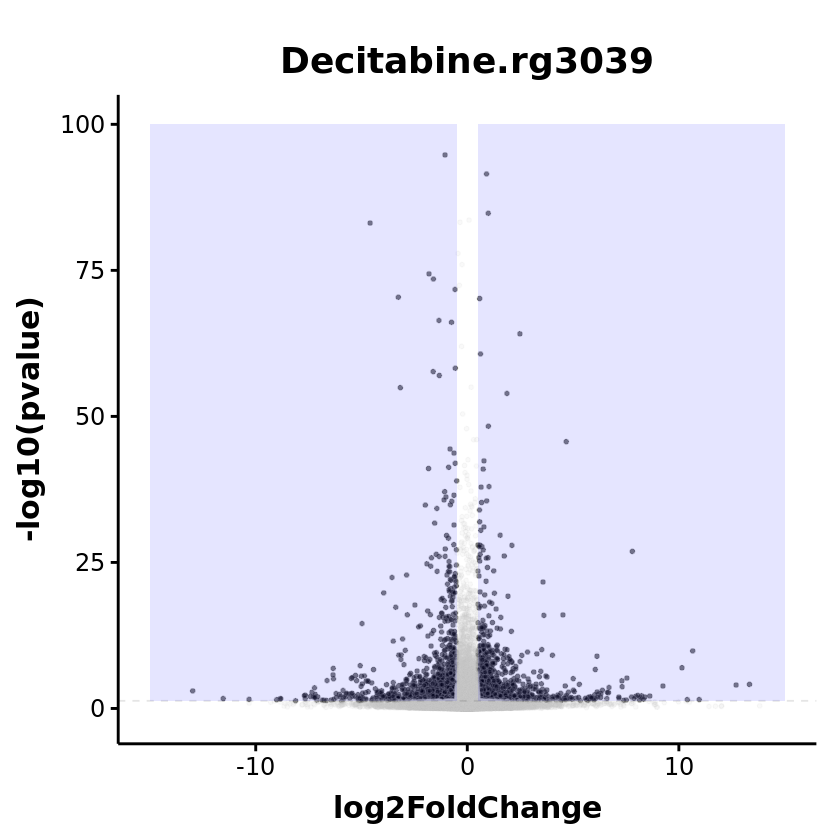

In [150]:
vol

In [124]:
# lfc.cutoff = .5
# pval.cutoff = 0.01
# colors_values = c("grey80", "black")
# x_min = -30
# x_max = 30


# plot_Volcano(
#     res_comb_vs_decitabine %>% ann_Result %>% drop_na(),
#     lfc.cutoff, pval.cutoff,
#     title  = 'comb_vs_decitabine', 
#     labels=c(), 
#     x_min, x_max
# # ) + ylim(c(-1, 100))
# )

In [118]:
res_DecitabineTreated.rg3039Treated_sig = res_DecitabineTreated.rg3039Treated %>% 
    data.frame %>%
    drop_na() %>% 
    dplyr::filter(abs(log2FoldChange) > 1 & padj < 0.05) %>% ann_Result

In [121]:
res_DecitabineTreated.rg3039Treated_sig$gene_name

### Combination Treatment vs Decitabine

In [40]:
# model.matrix(~0+rg3039+Decitabine+Decitabine*rg3039, colData)

In [41]:
# dds3 <- DESeqDataSetFromTximport(txi.gene, colData, ~0+rg3039+Decitabine+Decitabine*rg3039)

# # Annova test
# dds3 <- DESeq(dds3, test="LRT", reduced=~1, parallel=TRUE)

In [42]:
# resultsNames(dds3)

In [43]:
# # contrast design: combination treatment vs decitabine
# res_comb_vs_decitabine  = results(dds3, contrast=list(
#     c('rg3039Treated','rg3039Treated.DecitabineTreated'),
#     c('rg3039NotTreated')
# ),listValues=c(1,-1)) %>% ann_Result

In [44]:
# res_comb_vs_decitabine %>% 
#     filter(pvalue < 0.01) %>% 
#     arrange(desc(log2FoldChange)) %>% head(3)

In [45]:
# plot_gene_counts(
#     dds2,
#     'ENSG00000283189.2','AC104452.1'
# )

### Save results

In [ ]:
# RES = list(res_comb_vs_dmso, res_comb_vs_decitabine)
# names (RES) <- c('comb_vs_dmso', 'comb_vs_decitabine')

In [52]:
# # temp file for running iPAGE 
# # write results 
# for (name in names(RES)){
#     print (name)
#     # write results 
#     RES[[name]] %>% 
#         mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% remove_rownames %>% 
#         dplyr::select('gene_name','log2FoldChange') %>% 
#         write_Result(paste(name,'_delta_exp.txt', sep=''),col=TRUE)
# }

In [53]:
# for (name in names(RES)){
#     print (name)
#     # write results 
#     RES[[name]] %>% 
#         arrange(gene_name) %>% 
#         dplyr::select('gene_id','gene_name','log2FoldChange','pvalue',everything()) %>% 
#         write_Result(paste(name,'_delta_exp_table.txt', sep=''),col=TRUE)
# }

In [54]:
# names(RES)

In [55]:
# result_table <- cbind(
#     RES[[1]] %>% select('gene_name','log2FoldChange','pvalue') %>% rename(comb_vs_dmso_log2FC=log2FoldChange,comb_vs_dmso_pvalue=pvalue),
#     RES[[2]] %>% select('log2FoldChange','pvalue') %>% rename(comb_vs_decitabine_log2FC=log2FoldChange,comb_vs_decitabine_pvalue=pvalue)
# )
# # result_table

## Plots

In [43]:
colors=c("#386cb0","white","#fdb462")

### Correlation matrix

In [39]:
library(Hmisc)
library(corrplot)
library(pheatmap)
library(ggcorrplot)

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following object is masked from ‘package:AnnotationDbi’:

    contents


The following object is masked from ‘package:Biobase’:

    contents


The following objects are masked from ‘package:base’:

    format.pval, units


corrplot 0.92 loaded



In [40]:
# all_fc <- result_table %>% select(ends_with("log2FC")) 
# colnames(all_fc) <- colnames(all_fc) %>% stringr::str_remove(pattern = "_log2FC") %>% unlist

In [41]:
corr <- rcorr(
    as.matrix(
        # all_fc %>% select('hl60_6h','hl60_72h','hl60_120h','kg1','molm14','ociaml2','ociaml3','thp1')
        ncu
    )
)

In [42]:
corr_p <- ggcorrplot(
    corr$r, 
    method = c("square", "circle"),
    # hc.order = TRUE,
    type = "upper", 
    p.mat = corr$p,
    
# ) + ggtitle(
#     "Differential RNA Expression\nCorrelation matrix"
) + ggplot2::scale_fill_gradient2(
    low = colors[1], high = colors[3], mid = colors[2], 
    midpoint = 0.95, limit = c(0.9, 1), space = "Lab"
) + theme(
    plot.title = element_text(
        # face = "bold",
        size = rel(1.5), hjust = 0.5),
    panel.background = element_blank(), 
    panel.border = element_blank(), 
    panel.grid.major = element_line(colour = "white"), 
    legend.title = element_blank(),
    # legend.position="bottom"
)

# ggsave('exp/plots/logFC_corr.pdf',width = 4, height = 4)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



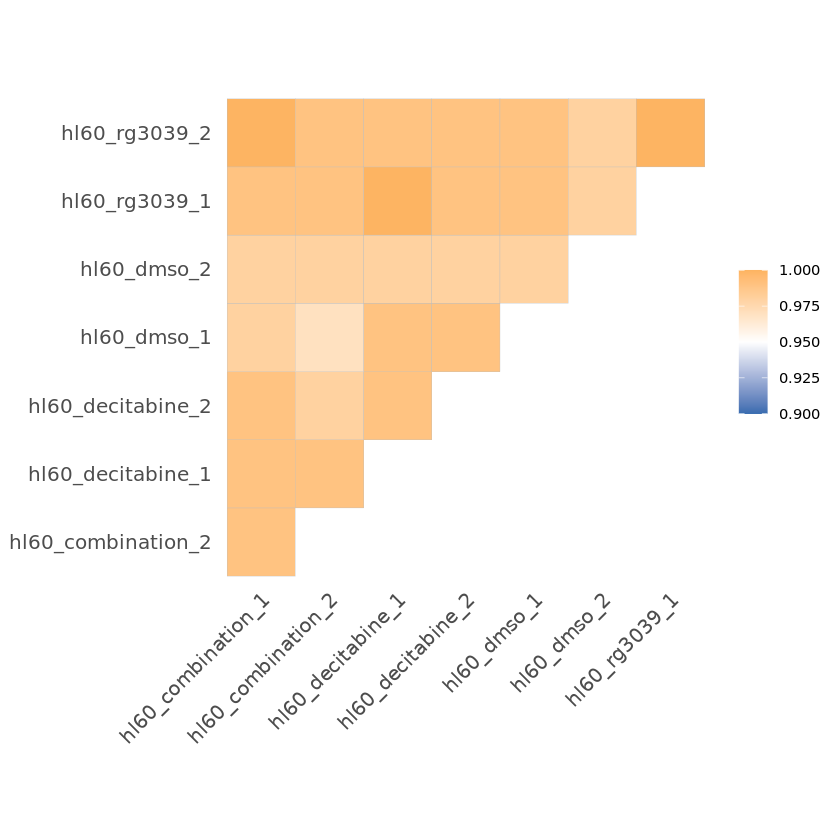

In [43]:
corr_p

I'm not sure if it's useful!

In [ ]:
lfc.cutoff = 1
pval.cutoff = 0.05
colors_values = c("grey80", "tan")
labels = c(
    'SQLE','INTS5'
)
x_min = -15
x_max = 15

### Scatter plot

In [29]:
source("../../scripts/util.R")

In [45]:
names(RES)

[1] "comb_vs_dmso"       "comb_vs_decitabine"

In [53]:
# RES$comb_vs_dmso$log2FoldChange
# RES$comb_vs_dmso$log2FoldChange

In [54]:
# plot_scatter()

### Volcano plots

In [44]:
plot_Volcano <- function (res, lfc.cutoff, pval.cutoff, title, labels, x_min, x_max) {

    res %>% 
        ggplot(aes(x = log2FoldChange, y = -log10(pvalue))) + 
        # significant points 
        geom_point(
            data=res %>% filter (abs(log2FoldChange) >= lfc.cutoff, pvalue < pval.cutoff),
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            size=1, alpha = 5/10,
            shape=21,color='grey40',fill=colors_values[2]
        ) + 
        # not significant points 
        geom_point(
            data=res %>% filter ((abs(log2FoldChange) < lfc.cutoff) | (pvalue >= pval.cutoff)),
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            size=1, alpha = 1/10,
            shape=21,color=colors_values[1],fill=colors_values[1]
        ) + 
        # highlights 
        geom_point(
            data=res %>% filter(gene_name %in% labels),
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            shape=21,size=3,color='grey40',fill='red3'
        ) + 
        geom_label_repel(
            data=res %>% filter(gene_name %in% labels),
            aes(label = gene_name), box.padding = 1, max.overlaps = Inf
        ) + 
        xlim(c(x_min, x_max)) + 
        geom_hline(yintercept = -log10(pval.cutoff),linetype = "dashed", alpha = 1/10) + 
        theme(legend.position = "none") + 
        ggtitle(title) + 
        theme_Publication() -> vol
    
    return(vol)
}

In [45]:

# plot_Volcano(
#     res_comb_vs_dmso %>% drop_na, 
#     title='Combination vs DMSO',
#     labels=c('MYL9')
# )

# vol_comb_vs_decitabine <- plot_Volcano(
#     res_comb_vs_decitabine %>% drop_na, 
#     title='Combination vs Decitabine',
# )

# plot_Volcano(
#     res_comb_vs_decitabine %>% drop_na, 
#     title='Combination vs Decitabine',
#     labels='AC104452.1'
# )

In [46]:
# vol_comb_vs_decitabine + vol_comb_vs_dmso

In [ ]:
VOL = list()

In [128]:
# VOL[['hl60_6h']] = plot_Volcano(
#     RES[['hl60_6h']] %>% drop_na(),
#     lfc.cutoff, pval.cutoff,
#     title  = 'HL60 - 6 hours treatment',
#     labels, x_min, x_max
# )

# VOL[['hl60_72h']] = plot_Volcano(
#     RES[['hl60_72h']] %>% drop_na(),
#     lfc.cutoff, pval.cutoff,
#     title  = 'HL60 - 72 hours treatment', 
#     labels, x_min, x_max
# )


# VOL[['hl60_72h_only']] = plot_Volcano(
#     RES[['hl60_72h_only']] %>% drop_na(),
#     lfc.cutoff, pval.cutoff, 
#     title  = 'HL60',
#     labels, x_min, x_max
# )

# VOL[['hl60_120h']] <- plot_Volcano(
#     RES[['hl60_120h']] %>% drop_na(),
#     lfc.cutoff, pval.cutoff,
#     title  = 'HL60 - 120 hours treatment', 
#     labels, x_min, x_max
# )

# # pdf('exp/plots/volcano_plots.pdf')
# for (name in  names(VOL)){
#     # print (VOL[[name]])    
#     ggsave(
#         paste0('exp/plots/volcano_',name,'.pdf'), 
#         plot = VOL[[name]], device = 'pdf', width = 5, height=5, dpi = 300
#     )
# }
# # dev.off()

# Session Info

In [143]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scales_1.1.1                ggthemes_4.2.4             
 [3] gridExtra_2.3               BiocParallel_1.28.0        
 [5] patchwork_1.1.1             DESeq2_1.34.0              
 [7] SummarizedExperiment_1.24.0 MatrixGenerics_1.6.0       
 [9] matrixStats_0.61.

In [67]:
date()

[1] "Tue Aug  2 17:58:51 2022"